In [1]:
import os
import math

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import Sequential
from tensorflow.keras.utils import Sequence
from datetime import timedelta
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import time

In [2]:
df = pd.read_csv(r'/work/data/Concat_data/Optima_faucet.csv')
df.head()

,Unnamed: 0,Consumption,Temp,FlowTime,Power_Consumption,TimeStamp,Unnamed: 0.1,Unnamed: 0.1.1,Unnamed: 0.1.1.1
0,294845,50.000000,40.000000,3600.000000,2.041666,2020-01-01 00:20:12,NaN,NaN,NaN
1,4842,50.000000,40.000000,3600.000000,2.041666,2020-01-01 00:20:12,76472.0,146272.0,NaN
2,4844,5.274300,42.407460,52.742992,0.230181,2020-01-01 00:20:21,76473.0,21111.0,16269.0
3,4843,5.274300,42.407460,52.742992,0.230181,2020-01-01 00:20:21,16269.0,NaN,NaN
4,4845,8.650353,25.918036,86.503525,0.211106,2020-01-01 01:00:13,76474.0,119687.0,114845.0


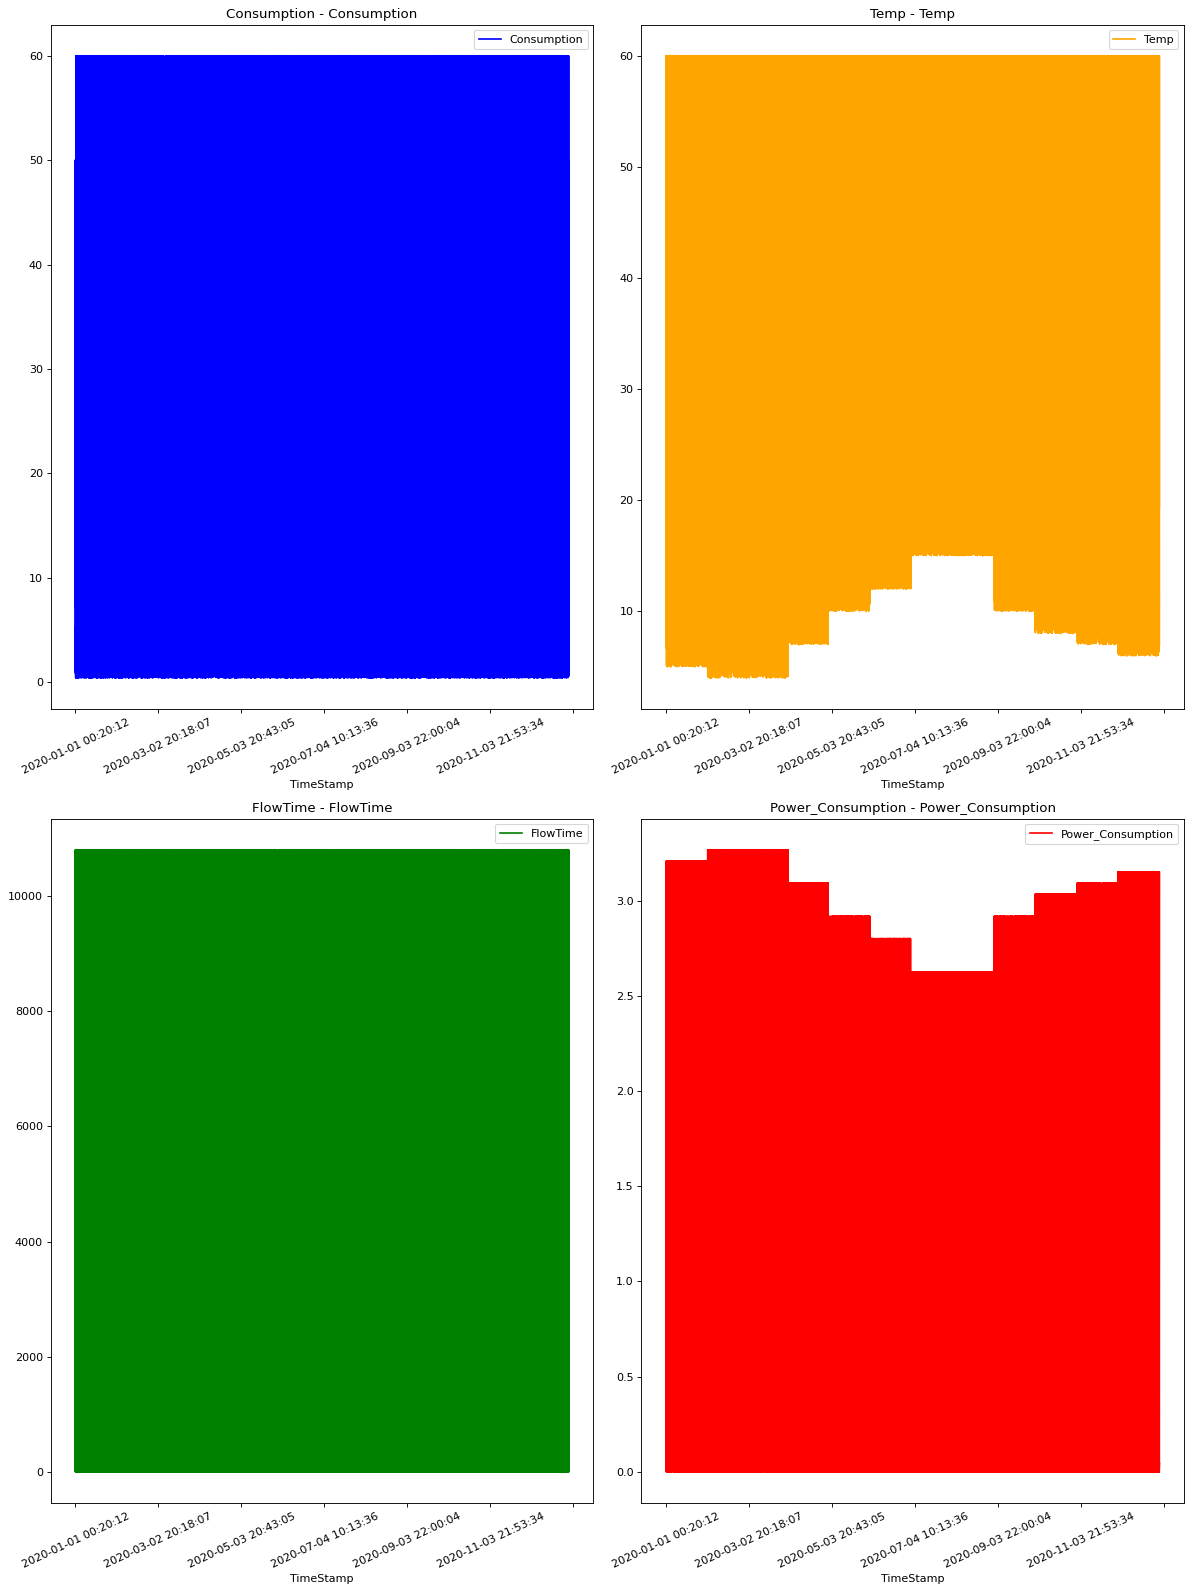

In [3]:
titles = [
    "Consumption",
    "Temp",
    "FlowTime",
    "Power_Consumption",
]

feature_keys = [
    "Consumption",
    "Temp",
    "FlowTime",
    "Power_Consumption",
]

colors = [
    "blue",
    "orange",
    "green",
    "red",
    "purple",
]

date_time_key = "TimeStamp"


def show_raw_visualization(data):
    time_data = data[date_time_key]
    fig, axes = plt.subplots(
        nrows=2, ncols=2, figsize=(15, 20), dpi=80, facecolor="w", edgecolor="k"
    )
    for i in range(len(feature_keys)):
        key = feature_keys[i]
        c = colors[i % (len(colors))]
        t_data = data[key]
        t_data.index = time_data
        t_data.head()
        ax = t_data.plot(
            ax=axes[i // 2, i % 2],
            color=c,
            title="{} - {}".format(titles[i], key),
            rot=25,
        )
        ax.legend([titles[i]])
    plt.tight_layout()


show_raw_visualization(df)

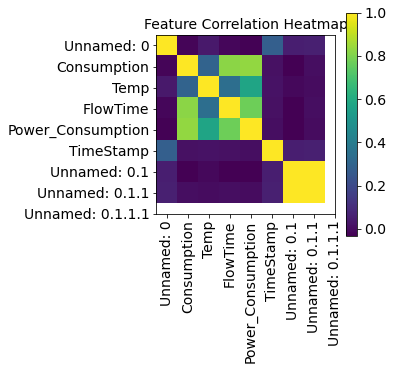

In [4]:
def show_heatmap(data):
    plt.matshow(data.corr())
    plt.xticks(range(data.shape[1]), data.columns, fontsize=14, rotation=90)
    plt.gca().xaxis.tick_bottom()
    plt.yticks(range(data.shape[1]), data.columns, fontsize=14)

    cb = plt.colorbar()
    cb.ax.tick_params(labelsize=14)
    plt.title("Feature Correlation Heatmap", fontsize=14)
    plt.show()


show_heatmap(df)

In [5]:
split_fraction = 0.7
train_split = int(split_fraction * int(df.shape[0]))
step = 6

past = 5000
future = 5000
learning_rate = 0.001
batch_size = 256
epochs = 2


def normalize(data, train_split):
    data_mean = data[:train_split].mean(axis=0)
    data_std = data[:train_split].std(axis=0)
    return (data - data_mean) / data_std, data_mean, data_std


In [6]:
print(
    "The selected parameters are:",
    ", ".join([titles[i] for i in [0, 3]]),
)
selected_features = [feature_keys[i] for i in [0, 3]]
features = df[selected_features]
features.index = df[date_time_key]
features.head()

norm = normalize(features.values, train_split)
features = norm[0]

m_cons = norm[1][0]
m_pow = norm[1][1]
s_cons = norm[2][0]
s_pow = norm[2][1]

features = pd.DataFrame(features)
features.head()

train_data = features.loc[0 : train_split - 1]
val_data = features.loc[train_split:]

The selected parameters are: Consumption, Power_Consumption


In [7]:
start = past + future
end = start + train_split

x_train = train_data[[i for i in range(2)]].values
y_train = features.iloc[start:end][[1]]

sequence_length = int(past / step)

In [8]:
dataset_train = keras.preprocessing.timeseries_dataset_from_array(
    x_train,
    y_train,
    sequence_length=sequence_length,
    sampling_rate=step,
    batch_size=batch_size,
)

In [9]:
x_end = len(val_data) - past - future

label_start = train_split + past + future

x_val = val_data.iloc[:x_end][[i for i in range(2)]].values
y_val = features.iloc[label_start:][[1]]

dataset_val = keras.preprocessing.timeseries_dataset_from_array(
    x_val,
    y_val,
    sequence_length=sequence_length,
    sampling_rate=step,
    batch_size=batch_size,
)


for batch in dataset_train.take(1):
    inputs, targets = batch

print("Input shape:", inputs.numpy().shape)
print("Target shape:", targets.numpy().shape)

Input shape: (256, 833, 2)
Target shape: (256, 1)


In [10]:
inputs = keras.layers.Input(shape=(inputs.shape[1], inputs.shape[2]))
lstm_1 = keras.layers.LSTM(32)(inputs)
drop = keras.layers.Dropout(0.2)(lstm_1)
outputs = keras.layers.Dense(1)(drop)

model = keras.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer=keras.optimizers.Adam(learning_rate=learning_rate), loss="mse")
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 833, 2)]          0         
_________________________________________________________________
lstm (LSTM)                  (None, 32)                4480      
_________________________________________________________________
dropout (Dropout)            (None, 32)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 33        
Total params: 4,513
Trainable params: 4,513
Non-trainable params: 0
_________________________________________________________________


In [11]:
path_checkpoint = "optima_checkpoint.h5"
es_callback = keras.callbacks.EarlyStopping(monitor="val_loss", min_delta=0, patience=5)

modelckpt_callback = keras.callbacks.ModelCheckpoint(
    monitor="val_loss",
    filepath=path_checkpoint,
    verbose=1,
    save_weights_only=True,
    save_best_only=True,
)

history = model.fit(
    dataset_train,
    epochs=epochs,
    validation_data=dataset_val,
    callbacks=[es_callback, modelckpt_callback],
)

Epoch 1/2
793/793 [==============================] - 1726s 2s/step - loss: 1.1458 - val_loss: 1.0865

Epoch 00001: val_loss improved from inf to 1.08646, saving model to optima_checkpoint.h5
Epoch 2/2
793/793 [==============================] - 1442s 2s/step - loss: 1.1441 - val_loss: 1.0856

Epoch 00002: val_loss improved from 1.08646 to 1.08565, saving model to optima_checkpoint.h5


In [17]:
def visualize_loss(history, title):
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]
    epochs = range(len(loss))
    plt.figure()
    plt.plot(epochs, loss, "b", label="Training loss")
    plt.plot(epochs, val_loss, "r", label="Validation loss")
    plt.title(title)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

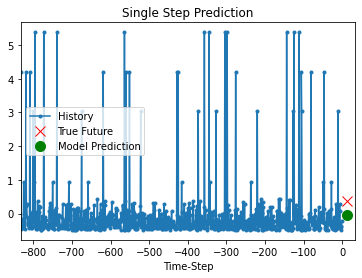

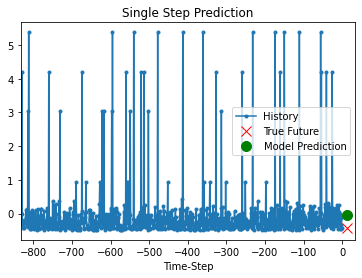

In [13]:
def show_plot(plot_data, delta, title):
    labels = ["History", "True Future", "Model Prediction"]
    marker = [".-", "rx", "go"]
    time_steps = list(range(-(plot_data[0].shape[0]), 0))
    if delta:
        future = delta
    else:
        future = 0

    plt.title(title)
    for i, val in enumerate(plot_data):
        if i:
            plt.plot(future, plot_data[i], marker[i], markersize=10, label=labels[i])
        else:
            plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
    plt.legend()
    plt.xlim([time_steps[0], (future + 5) * 2])
    plt.xlabel("Time-Step")
    plt.show()
    return


for x, y in dataset_val.take(2):
    show_plot(
        [x[0][:, 1].numpy(), y[0].numpy(), model.predict(x)[0]],
        12,
        "Single Step Prediction",
    )

In [14]:
count = 0

for x, y in dataset_val.take(2):
    if count == 0:
        print('consumption')
        print('predicted: ', y[0].numpy()[0] * s_cons + m_cons)
        print('actual: ', model.predict(x)[0][0] * s_cons + m_cons)
    else:
        print('power_consumption')
        print('predicted: ', y[0].numpy()[0] * s_pow + m_pow)
        print('actual: ', model.predict(x)[0][0] * s_pow + m_pow)
    count += 1


consumption
predicted:  12.947031509840794
actual:  8.437434249053865
power_consumption
predicted:  0.02777887000000001
actual:  0.22230736863461306


In [16]:
model.save("timeseries_optima.h5")

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=1a3b35bf-0652-423c-a6b7-6d55ba0a0a59' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>